<a href="https://colab.research.google.com/github/muhnatha/binary-machine-generated-code-detection/blob/main/%5BCOLAB%5D_main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hugging Face Token API Setup

In [1]:
# Check Token
from google.colab import userdata
from huggingface_hub import HfApi

api = HfApi()
HF_TOKEN = userdata.get('HF_TOKEN')

user = api.whoami(HF_TOKEN)
print("Logged in as:", user["name"])

Logged in as: lituldust


# Import Library

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Import Dataset

In [3]:
from google.colab import files

src = list(files.upload().values())[0]
open('mylib.py','wb').write(src)

Saving dataset.py to dataset.py


3893

In [4]:
from mylib import RawCodeDataset

train_dataset = RawCodeDataset(split='train', subsample=True, sample_size=5000)
val_dataset = RawCodeDataset(split='validation', subsample=True, sample_size=2000)
test_dataset = RawCodeDataset(split='test', subsample=False)

README.md:   0%|          | 0.00/801 [00:00<?, ?B/s]

task_a/task_a_training_set_1.parquet:   0%|          | 0.00/203M [00:00<?, ?B/s]

task_a/task_a_validation_set.parquet:   0%|          | 0.00/40.5M [00:00<?, ?B/s]

task_a/task_a_test_set_sample.parquet:   0%|          | 0.00/593k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/500000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/100000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/500000 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/500000 [00:00<?, ? examples/s]

Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/100000 [00:00<?, ? examples/s]

In [5]:
train_df = pd.DataFrame(list(train_dataset))
val_df = pd.DataFrame(list(val_dataset))
test_df = pd.DataFrame(list(test_dataset))

In [6]:
print("--SUMMARY--\n")
print(f"Number of train samples: {len(train_df)}")
print(f"Number of validation samples: {len(val_df)}")
print(f"Number of test samples: {len(test_df)}")


--SUMMARY--

Number of train samples: 5000
Number of validation samples: 2000
Number of test samples: 1000


In [7]:
train_df.head()

,code,label
0,"N = int(input())\nfor m in range(1, 10 ** 9):\...",0
1,total_number = int(input())\nmy_list = input()...,0
2,n = int(input())\nl = []\nfor i in range(n):\n...,0
3,n = int(input())\nsubstrs = input().split()\na...,0
4,java\nimport java.io.*;\nimport java.util.*;\n...,1


# Setup Training Configuration

In [8]:
import torch
from transformers import RobertaTokenizer, RobertaConfig, RobertaModel

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = RobertaTokenizer.from_pretrained("microsoft/codebert-base")
model = RobertaModel.from_pretrained("microsoft/codebert-base")
model.to(device)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/498 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

RobertaModel(
  (embeddings): RobertaEmbeddings(
    (word_embeddings): Embedding(50265, 768, padding_idx=1)
    (position_embeddings): Embedding(514, 768, padding_idx=1)
    (token_type_embeddings): Embedding(1, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): RobertaEncoder(
    (layer): ModuleList(
      (0-11): 12 x RobertaLayer(
        (attention): RobertaAttention(
          (self): RobertaSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): RobertaSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (dr

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

In [9]:
from torch.utils.data import Dataset, DataLoader

class CodeDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        # Extract code and label
        code_text = str(self.data.iloc[index].code)
        label = self.data.iloc[index].label

        # Tokenize the code
        encoding = self.tokenizer.encode_plus(
            code_text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Parameters
MAX_LEN = 512
BATCH_SIZE = 8

# Create DataLoaders
train_set = CodeDataset(train_df, tokenizer, MAX_LEN)
val_set = CodeDataset(val_df, tokenizer, MAX_LEN)
test_set = CodeDataset(test_df, tokenizer, MAX_LEN)

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE)

In [10]:
import torch.nn as nn

class CodeBERTClassifier(nn.Module):
    def __init__(self, base_model, n_classes):
        super(CodeBERTClassifier, self).__init__()
        self.bert = base_model
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

    def forward(self, input_ids, attention_mask):
        # output[0] is sequence_output, output[1] is pooled_output (CLS token)
        outputs = self.bert(
          input_ids=input_ids,
          attention_mask=attention_mask
        )

        # We use the pooled output (representation of the [CLS] token) for classification
        pooled_output = outputs[1]
        output = self.drop(pooled_output)
        return self.out(output)

# Initialize the full model
model_classifier = CodeBERTClassifier(model, n_classes=2)
model_classifier = model_classifier.to(device)

In [11]:
from torch.optim import AdamW

# Optimizer
optimizer = AdamW(model_classifier.parameters(), lr=2e-5)

# Loss function
loss_fn = nn.CrossEntropyLoss().to(device)

In [14]:
import torch
from tqdm.auto import tqdm

def train_epoch(model, data_loader, loss_fn, optimizer, device, n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0

    # Wrap the data_loader with tqdm for the progress bar
    # desc="Training" adds a label to the left of the bar
    progress_bar = tqdm(data_loader, desc="Training", leave=False)

    for d in progress_bar:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["labels"].to(device)

        # Forward pass
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)

        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())

        # Backward pass
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        optimizer.zero_grad()

        # Update the progress bar with the current batch loss
        progress_bar.set_postfix(loss=loss.item())

    return correct_predictions.double() / n_examples, sum(losses) / len(losses)

def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    losses = []
    correct_predictions = 0

    # Wrap validation loader with tqdm
    progress_bar = tqdm(data_loader, desc="Evaluating", leave=False)

    with torch.no_grad():
        for d in progress_bar:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["labels"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, targets)

            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())

            # Update progress bar with current validation loss
            progress_bar.set_postfix(loss=loss.item())

    return correct_predictions.double() / n_examples, sum(losses) / len(losses)

# Train Model

In [15]:
EPOCHS = 3

for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(
        model_classifier,
        train_loader,
        loss_fn,
        optimizer,
        device,
        len(train_df)
    )

    print(f'Train loss {train_loss} accuracy {train_acc}')

    val_acc, val_loss = eval_model(
        model_classifier,
        val_loader,
        loss_fn,
        device,
        len(val_df)
    )

    print(f'Val   loss {val_loss} accuracy {val_acc}')
    print()

Epoch 1/3
----------


Training:   0%|          | 0/625 [00:00<?, ?it/s]

Train loss 0.10100396071737631 accuracy 0.9762000000000001


Evaluating:   0%|          | 0/250 [00:00<?, ?it/s]

Val   loss 0.13388278734567574 accuracy 0.972

Epoch 2/3
----------


Training:   0%|          | 0/625 [00:00<?, ?it/s]

Train loss 0.08795469121588394 accuracy 0.9810000000000001


Evaluating:   0%|          | 0/250 [00:00<?, ?it/s]

Val   loss 0.10857188027212396 accuracy 0.977

Epoch 3/3
----------


Training:   0%|          | 0/625 [00:00<?, ?it/s]

Train loss 0.06299392736386508 accuracy 0.9866


Evaluating:   0%|          | 0/250 [00:00<?, ?it/s]

Val   loss 0.07740532884420827 accuracy 0.9805



# Predict

In [16]:
import torch
import torch.nn.functional as F

def get_predictions(model, data_loader, device):
    model = model.eval()

    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["labels"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            # Get the predicted class (highest probability)
            _, preds = torch.max(outputs, dim=1)

            # Get the probabilities
            probs = F.softmax(outputs, dim=1)

            predictions.extend(preds)
            prediction_probs.extend(probs)
            real_values.extend(targets)

    # Convert lists of tensors to standard tensors, then to CPU/Numpy
    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()

    return predictions, prediction_probs, real_values

# Run prediction
y_pred, y_probs, y_test = get_predictions(
    model_classifier,
    test_loader,
    device
)

In [17]:
from sklearn.metrics import classification_report, confusion_matrix

class_names = ['Human-Written', 'Machine-Generated']

print(classification_report(y_test, y_pred, target_names=class_names))

                   precision    recall  f1-score   support

    Human-Written       0.96      0.23      0.37       777
Machine-Generated       0.26      0.96      0.42       223

         accuracy                           0.39      1000
        macro avg       0.61      0.60      0.39      1000
     weighted avg       0.80      0.39      0.38      1000



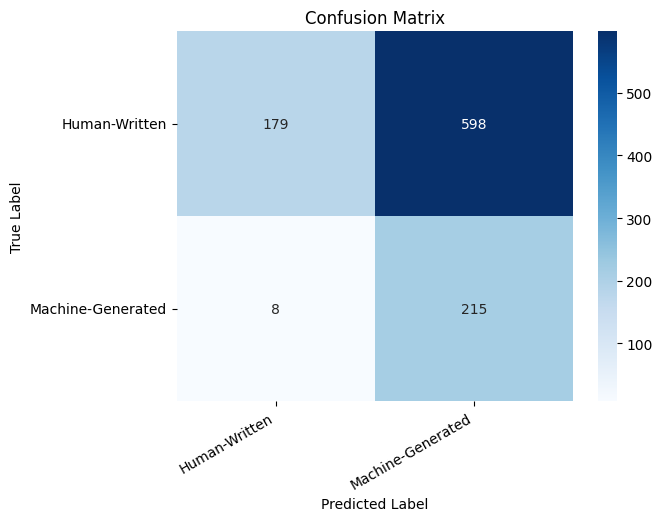

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title('Confusion Matrix')
    plt.show()

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)

show_confusion_matrix(df_cm)